In [1]:
from src.model import *
from src.lookup import *
from src.summarize import *
from src.checkpoint_util import *

In [2]:
# import opendatasets as od
# import transformers
import pandas as pd
import torch

import random 
import os
import numpy as np
# import math

import matplotlib.pyplot as plt

# import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

from transformers import RobertaTokenizer


seed = 1293182
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
fake_df = pd.read_csv('data/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('data/fake-and-real-news-dataset/True.csv')

In [4]:
fake_df['news'] = fake_df['text']
fake_df['news'] = fake_df['title'] + '\n' + fake_df['news']
fake_df['label'] = 0

In [5]:
true_df['news'] = true_df['text']
true_df['news'] = true_df['title'] + '\n' + true_df['news']
true_df['label'] = 1

In [6]:
all_data = pd.concat([true_df, fake_df])[['news', 'label']].sample(frac=1).reset_index(drop=True)

In [7]:
news_lens = {}

for news in all_data.news.values:
  news_len = len(news.split())
  if news_len in news_lens:
    news_lens[news_len] += 1
  else:
    news_lens[news_len] = 0

<BarContainer object of 1609 artists>

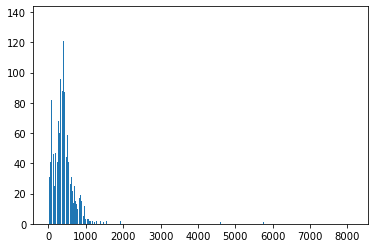

In [8]:
plt.bar(list(news_lens.keys()), list(news_lens.values()))

In [9]:
config  =  {'model':"roberta-base",
            'maxlen' :512,
            'train_batch_size':1,
            'valid_batch_size':1,
            'epochs':1,
#             'learning_rates':[0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-5], #Custom lr proven to work well in my previous tasks
            'learning_rates':[0.5e-5, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-5],
            'max_grad_norm':10,
            'device':'cuda' if torch.cuda.is_available() else 'cpu'}

In [10]:
# Hyperparameters for summarization
N = 45
n = 15 # Input tokens size
m = 5 # Number of summaries in each window
k = 1 # Number of lookups in each window
p = 1/13

assert m > k, "Should be m > k"
assert n < N, "Should be n < N"
assert k < (N-1)/n - 1, f"Should be k < (N-1)/n - 1, but {k} < {(N-1)/n - 1}"
assert 0 <= p and p <= ((N-1)-n*(1+k))/(N*(m-k)), f"0 <= {p} <= {((N-1)-n*(1+k))/(N*(m-k))} is not satisfied"


In [11]:
import torch

use_finetuned = False
model_config = RobertaConfig(
    _name_or_path="roberta-base",
    architectures=["RobertaForMaskedLM"],
    bos_token_id= 0,
    classifier_dropout=None,
    eos_token_id=2,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    hidden_size=768,
    initializer_range=0.02,
    intermediate_size=3072,
    layer_norm_eps=1e-05,
    max_position_embeddings=514,
    model_type="roberta",
    num_attention_heads=12,
    num_hidden_layers=12,
    pad_token_id=1,
    position_embedding_type="absolute",
    transformers_version="4.15.0",
    type_vocab_size=1,
    use_cache=True,
    vocab_size=50265,
    summarize_layers = [11],
    shrink_percentage = p,
    num_labels=2
)
if use_finetuned:
    tokenizer = RobertaTokenizer.from_pretrained("models")
else:
    tokenizer = RobertaTokenizer.from_pretrained(config['model'])

### 2.2 Set up a train, validation, and test set

I am opting for using 20% of the original dataset as the test set to make sure that the model generalizes well. The rest will be the train-val set.

In [12]:
from torch.utils.data import Dataset, DataLoader

class NewsClsDataset(Dataset):
    def __init__(self, df, tokenizer, maxlen=512):
        self.data = df
        self.tokenizer = tokenizer
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        text = self.data.news.values[index]
        labels = self.data.label.values[index]
        
        encoded = self.tokenizer(text.split(),
                                is_split_into_words=True,)
#                                 padding='max_length',
#                                 truncation=True,
#                                 max_length=self.maxlen)
        
        input_ids = encoded['input_ids'][1:]
        masks = encoded['attention_mask'][1:]        
            
        item = {'input_ids': torch.tensor(input_ids),
                'attention_masks': torch.tensor(masks),
                'labels': torch.tensor(labels)}

        return item
    
    def __len__(self):
        return len(self.data)

In [13]:
train_val_df, test_df = train_test_split(all_data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_dataset = NewsClsDataset(train_df, tokenizer, config['maxlen'])
val_dataset =  NewsClsDataset(val_df, tokenizer, config['maxlen'])
test_dataset = NewsClsDataset(test_df, tokenizer, config['maxlen'])

# TRAIN DATASET AND VALID DATASET
train_params = {'batch_size': config['train_batch_size'],
                'shuffle': True,
                'num_workers': 2,
                'pin_memory':True
                }

test_params = {'batch_size': config['valid_batch_size'],
                'shuffle': False,
                'num_workers': 2,
                'pin_memory':True
                }
train_data = DataLoader(train_dataset, **train_params)
val_data = DataLoader(val_dataset, **train_params)
test_data = DataLoader(test_dataset, **test_params)

#### Check for balanced label distribution before training

In [14]:
print("Distribution of train_val:", sum(train_val_df.label)/len(train_val_df))
print("Distribution of test:", sum(test_df.label)/len(test_df))

Distribution of train_val: 0.47708669747758786
Distribution of test: 0.4767260579064588


### 2.3 Create a dataset wrapper class

In [15]:
from tqdm import tqdm
import time

torch.autograd.set_detect_anomaly(True)
max_tokens = 32
model_name = f"test_run"
model_dir = "models"

# We warmed up with 128 indices before inserting tokens into embedding layer
last_epoch, last_idx, ckpt_info, model, tokenizer, optimizer = load_checkpoint(model_dir, model_name, config, model_config)
# print(ckpt_info)
# raise
if last_epoch == 0:
    last_epoch = 1
    nb_tr_steps = 0
    nb_tr_examples = 0
    tr_losses = 0
    tr_accuracies = 0
else:
    nb_tr_steps = ckpt_info["info"][-1]["Num Tr Steps"]
    nb_tr_examples = ckpt_info["info"][-1]["Num Tr Examples"]
    tr_losses = ckpt_info["info"][-1]["Training Loss"] * nb_tr_steps
    tr_accuracies = ckpt_info["info"][-1]["Training Acc"] * nb_tr_examples
    for i in range(len(ckpt_info["info"])):
        epoch = ckpt_info["info"][i]["epoch"]
        idx = ckpt_info["info"][i]["idx"]
        train_loss, val_loss = ckpt_info["info"][i]["Training Loss"], ckpt_info["info"][i]["Valid. Loss"]
        train_acc, val_acc = ckpt_info["info"][i]["Training Acc"], ckpt_info["info"][i]["Valid. Acc"]
        train_time, val_time = ckpt_info["info"][i]["Training Time"], ckpt_info["info"][i]["Valid. Time"]
        other_info = ckpt_info["info"][i]["Other"]
        print(f"Epoch: {epoch}, index: {idx}, Learning rate = {config['learning_rates'][epoch]}")
        print(f"Training loss epoch: {train_loss}")
        print(f"Training accuracy epoch: {train_acc}, elapsed: {train_time}")
        print(f"Val loss epoch: {val_loss}")
        print(f"Val accuracy epoch: {val_acc}, elapsed: {val_time}")
        print(f"Other: {other_info}")
        print()
    
for epoch in range(last_epoch, config['epochs']+1):
    config['learning_rates'][epoch] = 0.1e-5
    print(f"Epoch: {epoch}, Learning rate = {config['learning_rates'][epoch]}")
    for g in optimizer.param_groups: 
        g['lr'] = config['learning_rates'][epoch]
    lr = optimizer.param_groups[0]['lr']
    
    # Training
    train_time = 0
    
    model.train()
    for idx, batch in enumerate(tqdm(train_data)):
        if idx <= last_idx:            
            continue
        
#         print(f'batch["input_ids"]: {batch["input_ids"].shape}')
#         raise
#         if idx > 10:
#             break
        start_time = time.time()
        # Use 30 max last tokens, split into 3, feed first ten into next 10 and so on.
        # Then train using the last 10.
        summarized_tokens = None
        length = batch["input_ids"].shape[1]
        lt = LookupTable(config, N, n, m, k, p)
        for i in range(length // n): # Minus the BOS token
#             if i != 2:
#                 continue
            
            # Need to use batch size of 1 for now
            assert batch["input_ids"].shape[0] == 1, "Batch size must be 1 for now"
            
            ids = torch.zeros(1, 512)
            mask = torch.zeros(1, 512)
            end = min( n*(i+1), length )
            length_input_tokens = end - n*i
            
            ids[0,0] = 0 # BOS token
            ids[0,1:length_input_tokens+1] = batch['input_ids'][0, n*i : end].clone()
            ids[0,length_input_tokens+1:] = 1 # Padding
            mask[0,:length_input_tokens+1] = 1
            mask[0,length_input_tokens+1:] = 0 # Masks the padding
#             print(f"Tokens: {n*i} : {end}")
#             print(f"ids: {ids.shape}, mask: {mask.shape}")
#             raise
            
            ids = ids.to(config['device'], dtype = torch.long) #[C, seq_length]
            mask = mask.to(config['device'], dtype = torch.long)
            labels = batch['labels'].to(config['device'], dtype = torch.long)

            (loss, tr_logits), summarized_tokens_list = model(input_ids=ids, 
                                    attention_mask=mask, 
                                    labels=labels,
                                    return_dict=False,
                                    summarized_tokens=summarized_tokens)
            summarized_tokens = summarized_tokens_list[0].detach()
#             print(summarized_tokens.shape)
                
            # Track three types of losses separately
            tr_losses += loss.item()
            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
                

            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            flattened_predictions = torch.argmax(tr_logits, axis=1)

            tr_accuracies += sum(flattened_predictions==flattened_targets)

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=config['max_grad_norm']
            )

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Summary hierarchy
            lt.add(summarized_tokens, model, optimizer, labels, i, length)
            
            # This part should be in the LookupTable as well
            # nth
            max_order = max(lt.summarized_tokens_hierarchy.keys())
            max_order = max_order if len(lt.summarized_tokens_hierarchy[max_order]["summary_tokens"]) < 2 else max_order-1
            if max_order <= 2:
                l = []
            else:
                l = [lt.summarized_tokens_hierarchy[
                    max_order
                ]["summary_tokens"][0]]
            l = []
        
            # 1 2nd
            if max_order < 2 or len(lt.summarized_tokens_hierarchy[2]["summary_tokens"]) < 2:
                pass
            elif lt.summarized_tokens_hierarchy[2]["summary_tokens"][-1].shape[0] == 0:
                l.append(lt.summarized_tokens_hierarchy[2]["summary_tokens"][-2])
            else:
                l.append(lt.summarized_tokens_hierarchy[2]["summary_tokens"][-1])
            
            # 3 1st
            if lt.summarized_tokens_hierarchy[1]["summary_tokens"][-1].shape[0] == 0:
                l.extend(lt.summarized_tokens_hierarchy[1]["summary_tokens"][-4:-1])
            else:
                l.extend(lt.summarized_tokens_hierarchy[1]["summary_tokens"][-3:])

            summarized_tokens = torch.concat(l)
        
        train_time += time.time() - start_time
        
        if idx % 10 == 0: #TODO: Magic number
            train_loss = tr_losses / nb_tr_steps
            train_acc = tr_accuracies / nb_tr_examples
#             print(tr_losses)
            print(f"Epoch_loss:", train_loss)
            print("Acc:", train_acc)
            train_time /= 5

            save_checkpoint(model, tokenizer,
                            model_dir, model_name, config, 
                            epoch, idx,
                            train_loss, 0, train_acc, 0, train_time, 0,
                            nb_tr_steps, nb_tr_examples,
                            {})
            train_time = 0
            
    break #One epoch is enough

Can't find checkpoint: "ckpt-test_run.json", using downloaded pretrained model


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Epoch: 1, Learning rate = 1e-06


  0%|                                                 | 0/32326 [00:00<?, ?it/s]/home/tst008/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch_loss: 0.5833278620243072
Acc: tensor(1., device='cuda:0')
Length of current stats file: 0



  0%|                                    | 10/32326 [02:44<150:08:02, 16.72s/it]

Epoch_loss: 0.632700239623451
Acc: tensor(0.7432, device='cuda:0')
Length of current stats file: 1



  0%|                                    | 20/32326 [06:39<224:46:16, 25.05s/it]

Epoch_loss: 0.6795808264425999
Acc: tensor(0.5898, device='cuda:0')
Length of current stats file: 2



  0%|                                    | 30/32326 [17:55<617:16:06, 68.81s/it]

Epoch_loss: 0.4532690116523839
Acc: tensor(0.7427, device='cuda:0')
Length of current stats file: 3



  0%|                                    | 40/32326 [21:15<171:53:04, 19.17s/it]

Epoch_loss: 0.4643302996892941
Acc: tensor(0.7534, device='cuda:0')
Length of current stats file: 4



  0%|                                    | 50/32326 [26:28<313:54:12, 35.01s/it]

Epoch_loss: 0.51992806087924
Acc: tensor(0.6945, device='cuda:0')
Length of current stats file: 5



  0%|                                    | 60/32326 [29:48<150:52:58, 16.83s/it]

Epoch_loss: 0.5336239476397325
Acc: tensor(0.6869, device='cuda:0')
Length of current stats file: 6



  0%|                                    | 70/32326 [33:37<148:36:05, 16.58s/it]

Epoch_loss: 0.5487584895288491
Acc: tensor(0.6716, device='cuda:0')
Length of current stats file: 7



  0%|                                    | 80/32326 [37:09<152:50:04, 17.06s/it]

Epoch_loss: 0.556942673282296
Acc: tensor(0.6636, device='cuda:0')
Length of current stats file: 8



  0%|                                    | 90/32326 [39:27<137:37:32, 15.37s/it]

Epoch_loss: 0.5391476134410118
Acc: tensor(0.6816, device='cuda:0')
Length of current stats file: 9



  0%|                                   | 100/32326 [42:30<113:41:31, 12.70s/it]

Epoch_loss: 0.5050356712669104
Acc: tensor(0.7040, device='cuda:0')
Length of current stats file: 10



  0%|                                   | 110/32326 [45:36<111:05:20, 12.41s/it]

Epoch_loss: 0.502774713171381
Acc: tensor(0.7132, device='cuda:0')
Length of current stats file: 11



  0%|▏                                  | 120/32326 [49:15<198:09:48, 22.15s/it]

Epoch_loss: 0.4950568873956935
Acc: tensor(0.7242, device='cuda:0')
Length of current stats file: 12



  0%|▏                                  | 130/32326 [53:53<247:25:05, 27.67s/it]

Epoch_loss: 0.47773607927795403
Acc: tensor(0.7378, device='cuda:0')
Length of current stats file: 13



  0%|▏                                  | 140/32326 [58:48<344:57:34, 38.58s/it]

Epoch_loss: 0.44741483985085223
Acc: tensor(0.7564, device='cuda:0')
Length of current stats file: 14



  0%|▏                                | 150/32326 [1:02:18<234:29:58, 26.24s/it]

Epoch_loss: 0.4211548424884024
Acc: tensor(0.7714, device='cuda:0')
Length of current stats file: 15



  0%|▏                                | 160/32326 [1:06:41<156:16:32, 17.49s/it]

Epoch_loss: 0.39533801206255575
Acc: tensor(0.7856, device='cuda:0')
Length of current stats file: 16



  1%|▏                                | 170/32326 [1:10:35<231:13:54, 25.89s/it]

Epoch_loss: 0.38245627099247853
Acc: tensor(0.7950, device='cuda:0')
Length of current stats file: 17



  1%|▏                                | 180/32326 [1:13:51<175:31:18, 19.66s/it]

Epoch_loss: 0.37592672439320296
Acc: tensor(0.7995, device='cuda:0')
Length of current stats file: 18



  1%|▏                                | 190/32326 [1:18:23<278:54:27, 31.24s/it]

Epoch_loss: 0.365211042453461
Acc: tensor(0.8073, device='cuda:0')
Length of current stats file: 19



  1%|▏                                | 200/32326 [1:22:29<207:31:55, 23.26s/it]

Epoch_loss: 0.3612876267904618
Acc: tensor(0.8094, device='cuda:0')
Length of current stats file: 20



  1%|▏                                | 210/32326 [1:25:39<105:35:36, 11.84s/it]

Epoch_loss: 0.34890657535979236
Acc: tensor(0.8164, device='cuda:0')
Length of current stats file: 21



  1%|▏                                | 220/32326 [1:30:24<210:42:18, 23.63s/it]

Epoch_loss: 0.33799237141703264
Acc: tensor(0.8236, device='cuda:0')
Length of current stats file: 22



  1%|▏                                | 230/32326 [1:33:32<117:50:37, 13.22s/it]

Epoch_loss: 0.3319111547400034
Acc: tensor(0.8272, device='cuda:0')
Length of current stats file: 23



  1%|▏                                | 240/32326 [1:36:53<187:19:26, 21.02s/it]

Epoch_loss: 0.3199207356713334
Acc: tensor(0.8336, device='cuda:0')
Length of current stats file: 24



  1%|▎                                | 250/32326 [1:41:55<418:40:59, 46.99s/it]

Epoch_loss: 0.3228170350863757
Acc: tensor(0.8353, device='cuda:0')
Length of current stats file: 25



  1%|▎                                | 260/32326 [1:44:57<181:48:05, 20.41s/it]

Epoch_loss: 0.3277778703368876
Acc: tensor(0.8342, device='cuda:0')
Length of current stats file: 26



  1%|▎                                | 270/32326 [1:48:01<170:23:58, 19.14s/it]

Epoch_loss: 0.32164659377059707
Acc: tensor(0.8376, device='cuda:0')
Length of current stats file: 27



  1%|▎                                | 280/32326 [1:51:21<110:42:50, 12.44s/it]

Epoch_loss: 0.31503887485888893
Acc: tensor(0.8415, device='cuda:0')
Length of current stats file: 28



  1%|▎                                | 290/32326 [1:55:20<161:43:30, 18.17s/it]

Epoch_loss: 0.32013807149006707
Acc: tensor(0.8393, device='cuda:0')
Length of current stats file: 29



  1%|▎                                | 300/32326 [1:58:18<179:53:21, 20.22s/it]

Epoch_loss: 0.3135947890054157
Acc: tensor(0.8432, device='cuda:0')
Length of current stats file: 30



  1%|▎                                | 310/32326 [2:01:26<192:05:25, 21.60s/it]

Epoch_loss: 0.3050434699841196
Acc: tensor(0.8475, device='cuda:0')
Length of current stats file: 31



  1%|▎                                | 320/32326 [2:04:18<119:02:24, 13.39s/it]

Epoch_loss: 0.2976613443377975
Acc: tensor(0.8513, device='cuda:0')
Length of current stats file: 32



  1%|▎                                | 330/32326 [2:07:35<134:47:10, 15.17s/it]

Epoch_loss: 0.28956321525917916
Acc: tensor(0.8553, device='cuda:0')
Length of current stats file: 33



  1%|▎                                | 340/32326 [2:10:07<147:28:54, 16.60s/it]

Epoch_loss: 0.28783048738489425
Acc: tensor(0.8574, device='cuda:0')
Length of current stats file: 34



  1%|▎                                | 350/32326 [2:13:26<126:00:59, 14.19s/it]

Epoch_loss: 0.28140781026409684
Acc: tensor(0.8608, device='cuda:0')
Length of current stats file: 35



  1%|▎                                | 360/32326 [2:16:11<143:48:23, 16.20s/it]

Epoch_loss: 0.2756917376247155
Acc: tensor(0.8636, device='cuda:0')
Length of current stats file: 36



  1%|▍                                | 370/32326 [2:19:05<180:42:00, 20.36s/it]

Epoch_loss: 0.269767043963895
Acc: tensor(0.8667, device='cuda:0')
Length of current stats file: 37



  1%|▍                                 | 380/32326 [2:21:33<87:07:47,  9.82s/it]

Epoch_loss: 0.26440321766868585
Acc: tensor(0.8694, device='cuda:0')
Length of current stats file: 38



  1%|▍                                | 390/32326 [2:24:09<158:46:46, 17.90s/it]

Epoch_loss: 0.26016691441021433
Acc: tensor(0.8715, device='cuda:0')
Length of current stats file: 39



  1%|▍                                | 400/32326 [2:28:05<175:04:16, 19.74s/it]

Epoch_loss: 0.2531548302162783
Acc: tensor(0.8750, device='cuda:0')
Length of current stats file: 40



  1%|▍                                 | 410/32326 [2:30:45<91:38:00, 10.34s/it]

Epoch_loss: 0.2484686691202423
Acc: tensor(0.8774, device='cuda:0')
Length of current stats file: 41



  1%|▍                                | 420/32326 [2:34:29<262:14:03, 29.59s/it]

Epoch_loss: 0.2426541232248069
Acc: tensor(0.8802, device='cuda:0')
Length of current stats file: 42



  1%|▍                                | 430/32326 [2:36:57<128:13:04, 14.47s/it]

Epoch_loss: 0.23857255288782073
Acc: tensor(0.8823, device='cuda:0')
Length of current stats file: 43



  1%|▍                                | 440/32326 [2:40:58<242:54:41, 27.43s/it]

Epoch_loss: 0.2321434154655509
Acc: tensor(0.8854, device='cuda:0')
Length of current stats file: 44



  1%|▍                                | 450/32326 [2:44:26<191:12:04, 21.59s/it]

Epoch_loss: 0.22763078270523202
Acc: tensor(0.8876, device='cuda:0')
Length of current stats file: 45



  1%|▍                                | 460/32326 [2:48:29<218:51:38, 24.73s/it]

Epoch_loss: 0.22192563050904868
Acc: tensor(0.8905, device='cuda:0')
Length of current stats file: 46



  1%|▍                                | 470/32326 [2:52:46<262:34:17, 29.67s/it]

Epoch_loss: 0.21671571432564146
Acc: tensor(0.8930, device='cuda:0')
Length of current stats file: 47



  1%|▍                                | 480/32326 [2:57:09<190:04:34, 21.49s/it]

Epoch_loss: 0.21161467962577518
Acc: tensor(0.8955, device='cuda:0')
Length of current stats file: 48



  2%|▌                                 | 490/32326 [2:59:20<97:12:01, 10.99s/it]

Epoch_loss: 0.20858485498828683
Acc: tensor(0.8970, device='cuda:0')
Length of current stats file: 49



  2%|▌                                | 500/32326 [3:02:38<182:41:15, 20.66s/it]

Epoch_loss: 0.2045119055467553
Acc: tensor(0.8991, device='cuda:0')
Length of current stats file: 50



  2%|▌                                | 510/32326 [3:05:47<113:33:52, 12.85s/it]

Epoch_loss: 0.20083629574571696
Acc: tensor(0.9009, device='cuda:0')
Length of current stats file: 51



  2%|▌                                | 520/32326 [3:10:08<298:28:06, 33.78s/it]

Epoch_loss: 0.19653605524781687
Acc: tensor(0.9030, device='cuda:0')
Length of current stats file: 52



  2%|▌                                | 530/32326 [3:16:53<284:36:41, 32.22s/it]

Epoch_loss: 0.19116357498882783
Acc: tensor(0.9058, device='cuda:0')
Length of current stats file: 53



  2%|▌                                | 540/32326 [3:20:15<213:43:14, 24.21s/it]

Epoch_loss: 0.18720899995231743
Acc: tensor(0.9077, device='cuda:0')
Length of current stats file: 54



  2%|▌                                 | 550/32326 [3:22:31<70:25:21,  7.98s/it]

Epoch_loss: 0.18544557987069088
Acc: tensor(0.9086, device='cuda:0')
Length of current stats file: 55



  2%|▌                                | 560/32326 [3:25:24<177:53:28, 20.16s/it]

Epoch_loss: 0.1827116265816542
Acc: tensor(0.9099, device='cuda:0')
Length of current stats file: 56



  2%|▌                                 | 570/32326 [3:27:27<83:26:28,  9.46s/it]

Epoch_loss: 0.18075782273333452
Acc: tensor(0.9109, device='cuda:0')
Length of current stats file: 57



  2%|▌                                | 580/32326 [3:31:01<223:00:22, 25.29s/it]

Epoch_loss: 0.1779081411301333
Acc: tensor(0.9123, device='cuda:0')
Length of current stats file: 58



  2%|▌                                | 590/32326 [3:35:35<396:29:00, 44.98s/it]

Epoch_loss: 0.17417566877354573
Acc: tensor(0.9141, device='cuda:0')
Length of current stats file: 59



  2%|▌                                | 600/32326 [3:39:04<152:13:27, 17.27s/it]

Epoch_loss: 0.17142022379750782
Acc: tensor(0.9155, device='cuda:0')
Length of current stats file: 60



  2%|▌                                | 610/32326 [3:42:18<163:43:42, 18.58s/it]

Epoch_loss: 0.16858531114704126
Acc: tensor(0.9169, device='cuda:0')
Length of current stats file: 61



  2%|▋                                | 620/32326 [3:48:12<282:29:12, 32.07s/it]

Epoch_loss: 0.16459063827330625
Acc: tensor(0.9189, device='cuda:0')
Length of current stats file: 62



  2%|▋                                | 630/32326 [3:53:42<296:21:10, 33.66s/it]

Epoch_loss: 0.16118778143715226
Acc: tensor(0.9205, device='cuda:0')
Length of current stats file: 63



  2%|▋                                | 640/32326 [3:57:29<200:15:33, 22.75s/it]

Epoch_loss: 0.1586485751594023
Acc: tensor(0.9218, device='cuda:0')
Length of current stats file: 64



  2%|▋                                | 650/32326 [4:00:08<129:31:36, 14.72s/it]

Epoch_loss: 0.15641457705756262
Acc: tensor(0.9229, device='cuda:0')
Length of current stats file: 65



  2%|▋                                | 660/32326 [4:04:09<211:03:15, 23.99s/it]

Epoch_loss: 0.15403551064632154
Acc: tensor(0.9241, device='cuda:0')
Length of current stats file: 66



  2%|▋                                | 670/32326 [4:07:30<113:31:50, 12.91s/it]

Epoch_loss: 0.15200895394605532
Acc: tensor(0.9251, device='cuda:0')
Length of current stats file: 67



  2%|▋                                | 680/32326 [4:11:23<185:10:16, 21.06s/it]

Epoch_loss: 0.14960605025394352
Acc: tensor(0.9263, device='cuda:0')
Length of current stats file: 68



  2%|▋                                | 690/32326 [4:15:46<177:06:20, 20.15s/it]

Epoch_loss: 0.14683930461539696
Acc: tensor(0.9276, device='cuda:0')
Length of current stats file: 69



  2%|▋                                | 700/32326 [4:19:14<136:03:40, 15.49s/it]

Epoch_loss: 0.14501637277077167
Acc: tensor(0.9285, device='cuda:0')
Length of current stats file: 70



  2%|▋                                | 710/32326 [4:23:48<358:18:39, 40.80s/it]

Epoch_loss: 0.14256848259990185
Acc: tensor(0.9297, device='cuda:0')
Length of current stats file: 71



  2%|▋                                | 720/32326 [4:26:54<163:16:24, 18.60s/it]

Epoch_loss: 0.1408263649502721
Acc: tensor(0.9306, device='cuda:0')
Length of current stats file: 72



  2%|▋                                | 730/32326 [4:29:43<158:09:45, 18.02s/it]

Epoch_loss: 0.1393062782352885
Acc: tensor(0.9313, device='cuda:0')
Length of current stats file: 73



  2%|▊                                | 740/32326 [4:32:30<190:51:55, 21.75s/it]

Epoch_loss: 0.13773052355583645
Acc: tensor(0.9321, device='cuda:0')
Length of current stats file: 74



  2%|▊                                | 742/32326 [4:33:51<194:16:45, 22.14s/it]

KeyboardInterrupt

